In [1]:
suppressPackageStartupMessages({

library(GenomicRanges)
library(rtracklayer)
library(VariantAnnotation)
library(tidyverse)
library(glue)
library(here)
library(bdkn)

})

In [2]:
get_coverage <- function(bed, bam) { 
    paste("bedtools coverage -a", bed, "-b", bam, "-d") %>%
        pipe %>%
        read_tsv(col_names = c("chr", "start", "end", "pos", "coverage"),
                 col_types = "ciiii") %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE,
                                 keep.extra.columns = TRUE)
}

## Characteristics of three different capture sets after 50% mappability filtering

### Exome capture set - not filtered

In [3]:
bed <- import.bed(here("data/coord/capture_exome.bed"))

In [4]:
length(bed)

[1] 2519

In [5]:
width(bed) %>% sum

[1] 118643

In [6]:
import.bed("../tmp/ajhg2064mmc2_V1.txt") %>% width %>% sum

[1] 118643

In [7]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     1.0     3.0    47.1    67.5  1257.0 

### Lippold capture set

In [8]:
bed <- import.bed(here("data/coord/capture_lippold.bed"))

In [9]:
length(bed)

[1] 1779

In [10]:
width(bed) %>% sum

[1] 556259

In [11]:
import.bed("../input/basti_design.bed") %>% width %>% sum

[1] 573657

In [12]:
556259 / 573657

[1] 0.9696718

In [13]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   107.5   119.0   312.7   418.5  2829.0 

### Full Y chromosome capture set

In [14]:
bed <- import.bed(here("data/coord/capture_full.bed"))

In [15]:
length(bed)

[1] 15906

In [16]:
width(bed) %>% sum

[1] 6913053

In [17]:
read_delim("../input/Y.filt35_50_SRepeat_100.bed", delim = " ",
           col_names = c("chrom", "start", "end", "width"), col_types = "ciii") %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE) %>%
    width %>% sum

[1] 6913053

In [18]:
6913053 / 6913053

[1] 1

In [20]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   145.0   240.0   434.6   489.8  9425.0 

## Characteristics of three different capture sets after 100% mappability filtering

### Exome capture set

In [46]:
bed <- import.bed(here("data/coord/capture_exome.bed"))

In [47]:
length(bed)

[1] 1617

In [48]:
width(bed) %>% sum

[1] 43069

In [50]:
import.bed("../tmp/ajhg2064mmc2_V1.txt") %>% width %>% sum

[1] 118643

In [55]:
43069 / 118643

[1] 0.3630134

In [49]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    5.00   26.64   31.00  803.00 

### Lippold capture set

In [51]:
bed <- import.bed(here("data/coord/capture_lippold.bed"))

In [52]:
length(bed)

[1] 3657

In [53]:
width(bed) %>% sum

[1] 433416

In [54]:
import.bed("../input/basti_design.bed") %>% width %>% sum

[1] 573657

In [56]:
433416 / 573657

[1] 0.7555316

In [10]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   119.0   151.0   458.6   820.0  3899.0 

### Full Y chromosome capture set

In [41]:
bed <- import.bed(here("data/coord/capture_full.bed"))

In [42]:
length(bed)

[1] 48998

In [43]:
width(bed) %>% sum

[1] 4602444

In [44]:
read_delim("../input/Y.filt35_50_SRepeat_100.bed", delim = " ",
           col_names = c("chrom", "start", "end", "width"), col_types = "ciii") %>%
    makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE) %>%
    width %>% sum

[1] 6913053

In [45]:
4602444 / 6913053

[1] 0.6657614

In [14]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   145.0   240.0   434.6   489.8  9425.0 

# Calculate coverage for all three sets of capture regions

In [22]:
cov_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    str_subset("control", negate = TRUE) %>%
    map_dfr(function(bam) {
        name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
        regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
        bed <- here(glue("data/coord/capture_{regions}.bed"))
        coverage_df <-
            get_coverage(bed, bam) %>%
            as.data.frame %>%
            mutate(name = name, regions = regions) %>%
            rename(chrom = seqnames) %>%
            select(-width, -strand, -pos)
    }) %>%
    mutate(set = case_when(
        name %in% c("denisova8", "spy1", "mez2", "elsidron1", "elsidron2") ~ "capture",
        name %in% c("bichon", "kk1", "loschbour", "mota", "ustishim") ~ "shotgun_ancient",
        TRUE ~ "shotgun_modern"
    ))

ERROR: Error: vector memory exhausted (limit reached?)


In [4]:
factors <- c(
    filter(cov_df, set == "capture")$name %>% unique,
    filter(cov_df, set == "shotgun_ancient")$name %>% unique,
    filter(cov_df, set == "shotgun_modern")$name %>% unique
)

In [5]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

In [6]:
cov_df %>%
group_by(name, regions) %>%
summarise(avg_coverage = mean(coverage)) %>%
spread(regions, avg_coverage) %>%
.[match(factors, .$name), ]

name,exome,full,lippold
elsidron1,3.335300,NA,NA
denisova8,NA,3.6038601,NA
mez2,NA,1.5039062,NA
spy1,NA,0.9103632,NA
elsidron2,NA,NA,8.230427
bichon,4.267702,3.8886378,4.237166
kk1,5.628979,6.4398122,6.764789
loschbour,8.330513,10.7749450,10.089911
mota,5.339725,6.3702574,6.319020
ustishim,15.304106,20.3913371,19.877011


In [7]:
control_cov_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    str_subset("control") %>%
    map_dfr(function(bam) {
        name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
        regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
        bed <- here(glue("data/coord/capture_{regions}.bed"))
        coverage_df <-
            get_coverage(bed, bam) %>%
            as.data.frame %>%
            mutate(name = name, regions = regions) %>%
            rename("seqnames" = "chrom") %>%
            select(-width, -strand, -pos)
    })

In [25]:
control_cov_df %>%
group_by(name, regions) %>%
summarise(avg_coverage = mean(coverage)) %>%
spread(regions, avg_coverage)

name,exome,full,lippold
control_stuttgart,0.03195300,0.02831108,0.06171226
control_vindija,0.05848638,0.06643895,0.12580111


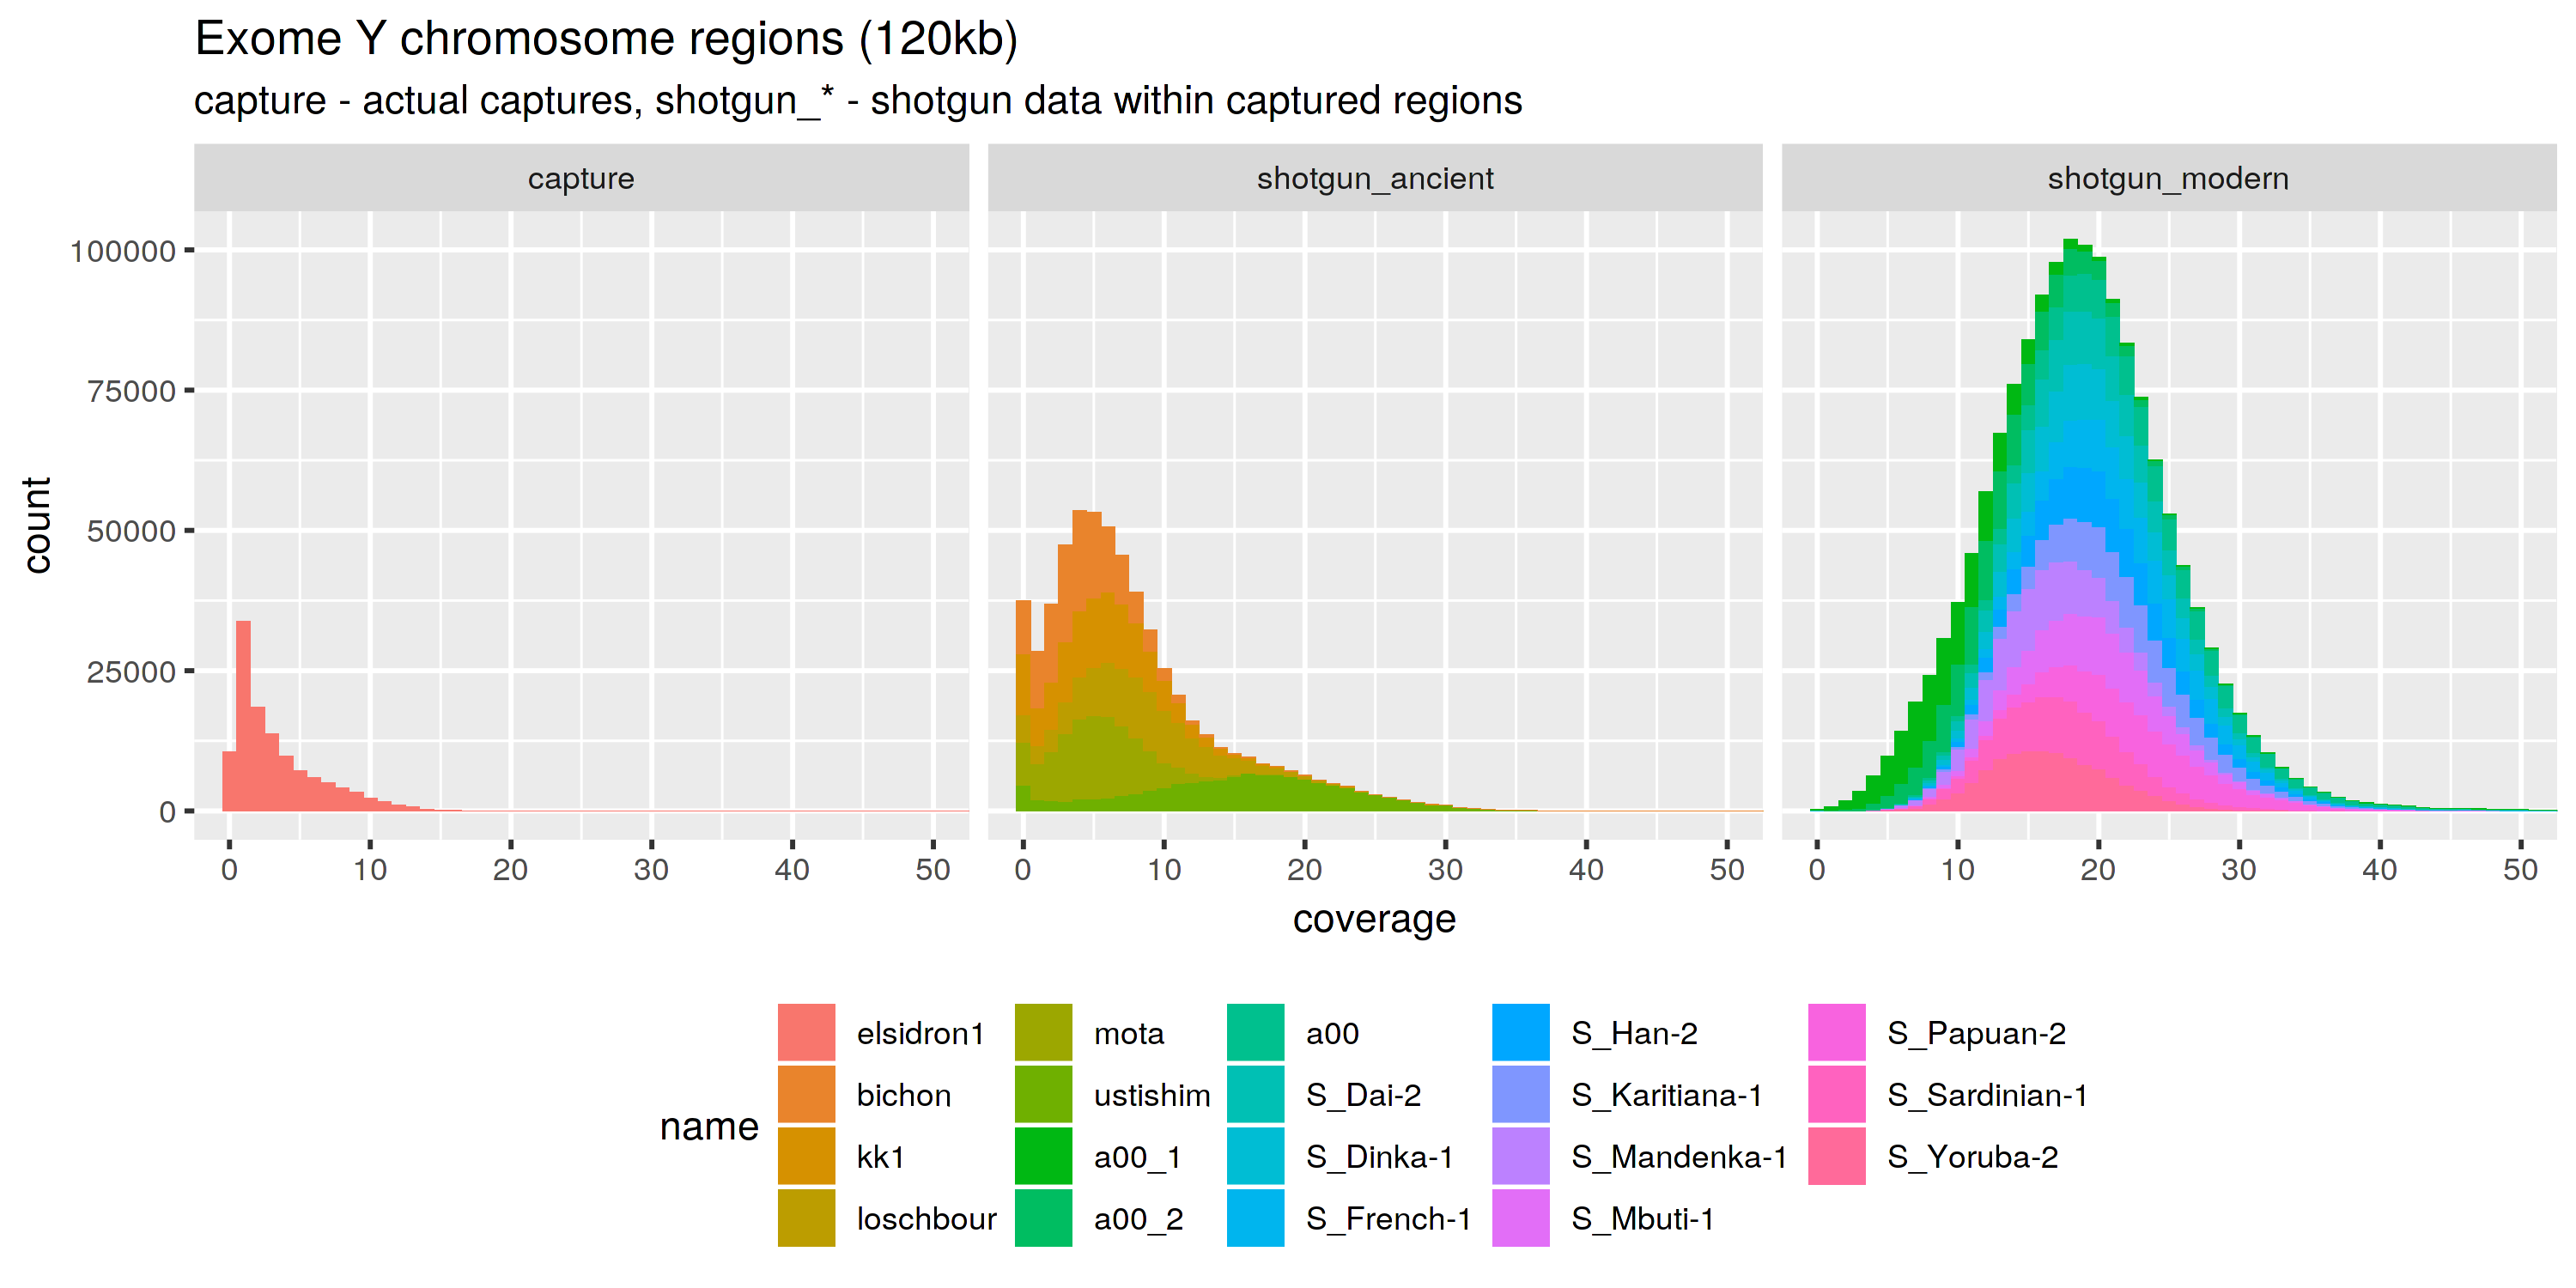

In [38]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "exome") %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ set) +
    theme(legend.position = "bottom") +
    ggtitle("Exome Y chromosome regions (120kb)",
            "capture - actual captures, shotgun_* - shotgun data within captured regions")

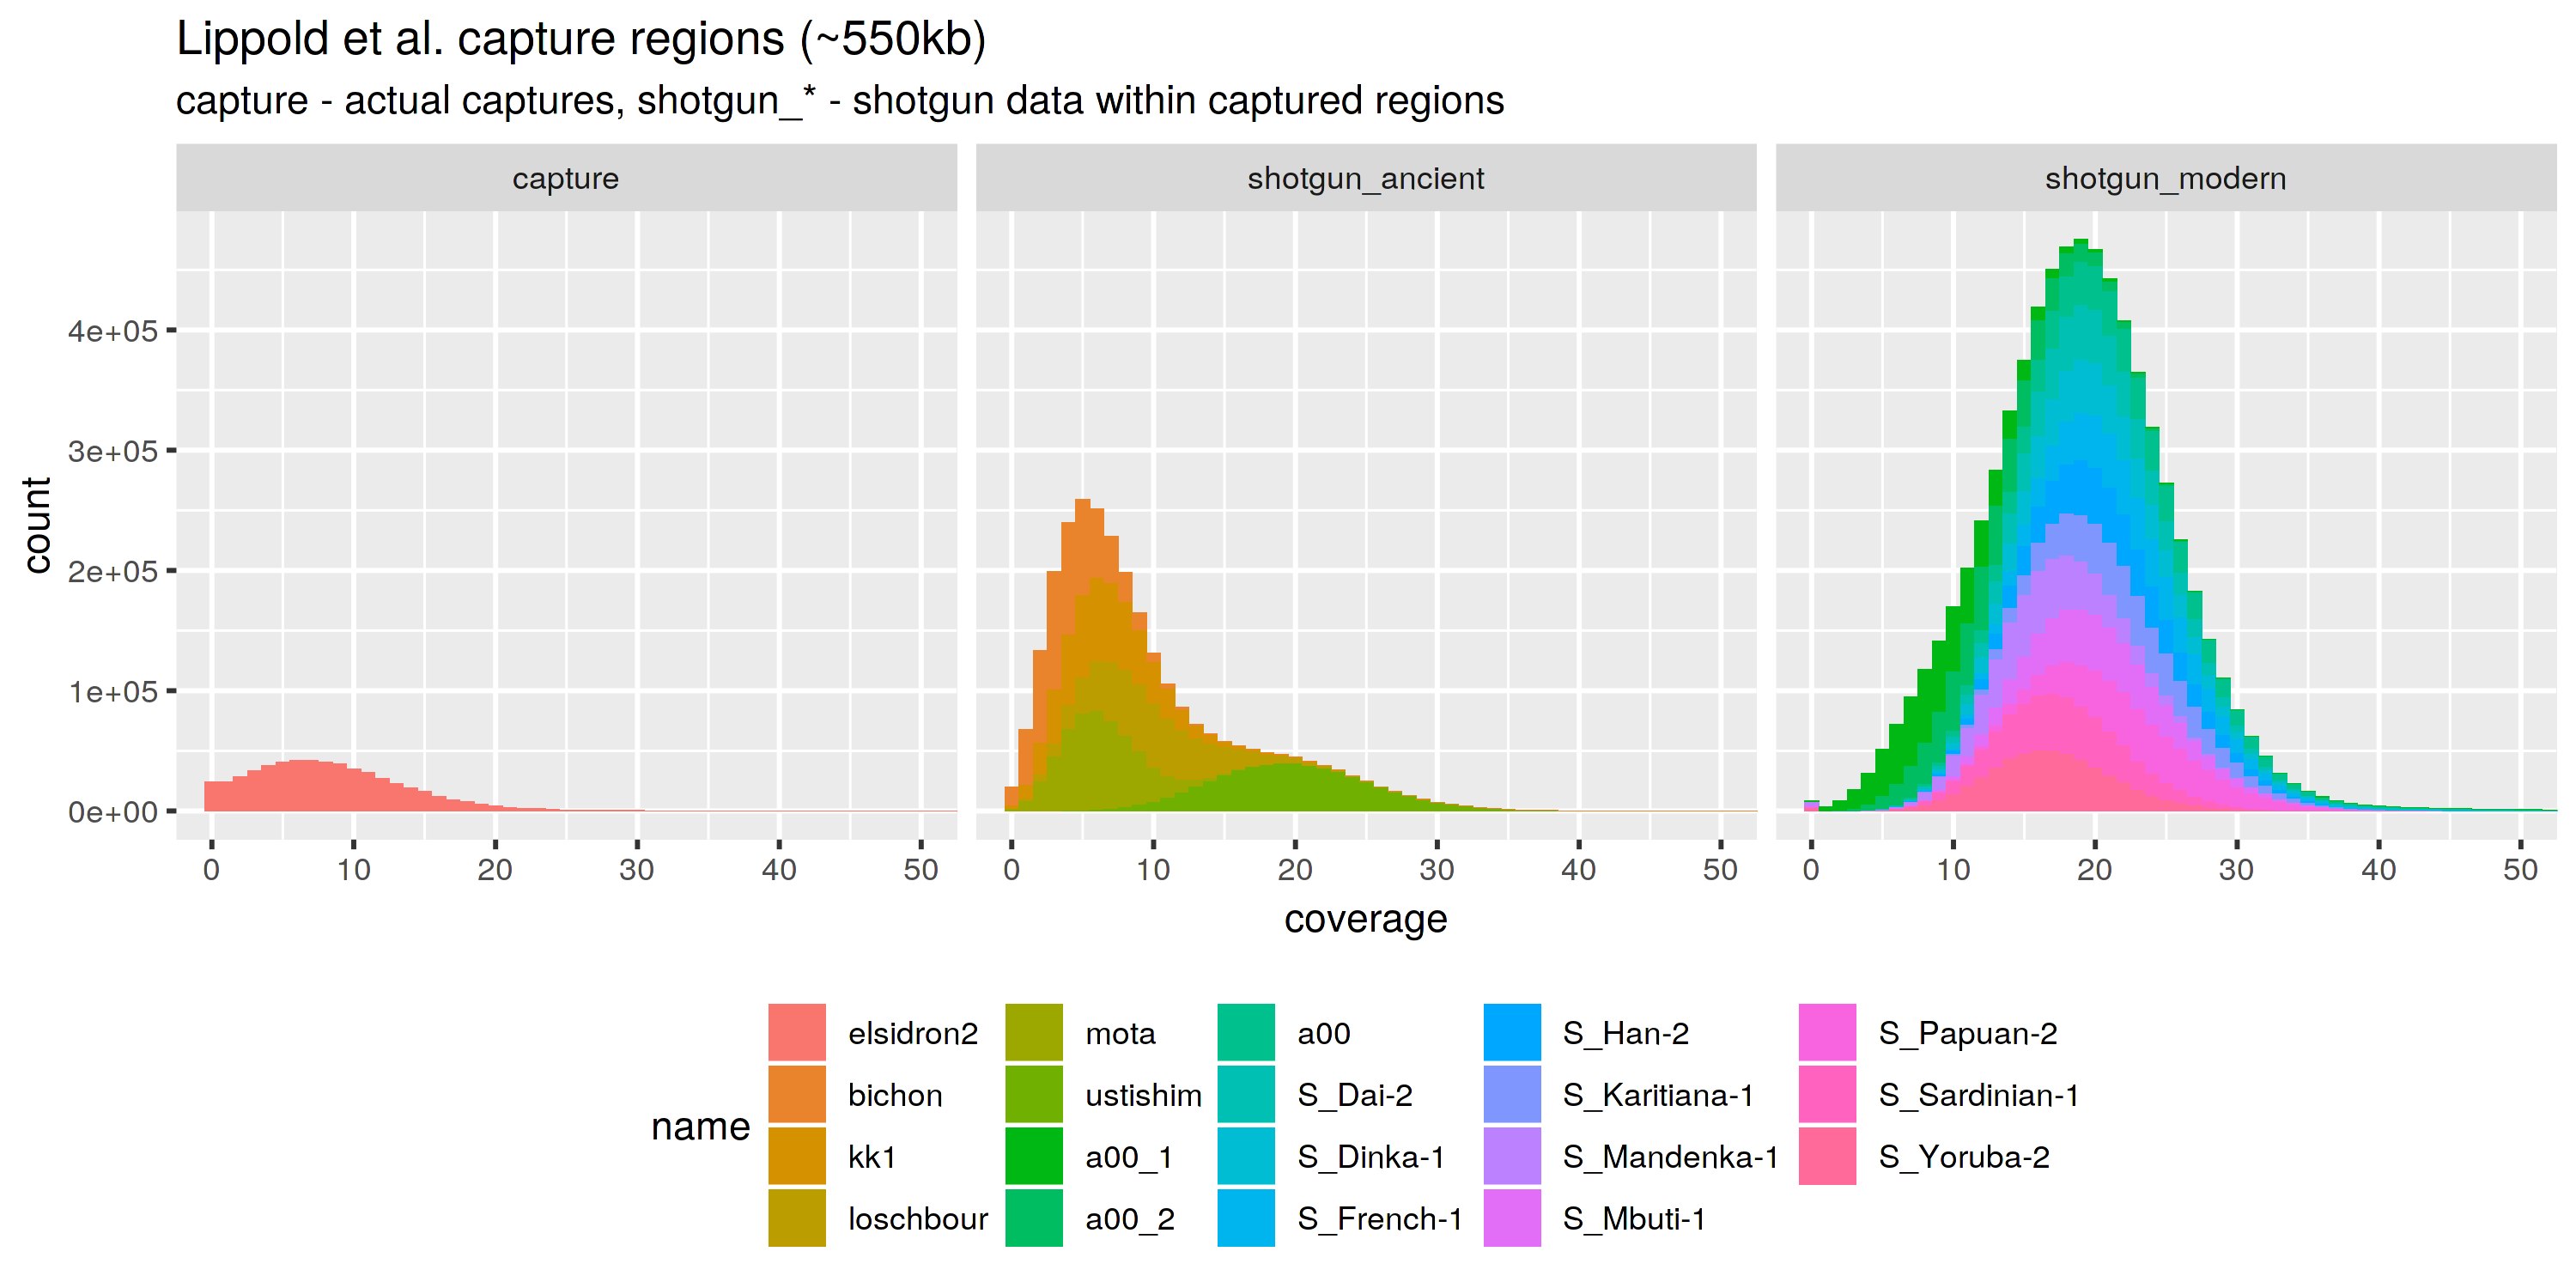

In [39]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "lippold") %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ set) +
    theme(legend.position = "bottom") +
    ggtitle("Lippold et al. capture regions (~550kb)",
            "capture - actual captures, shotgun_* - shotgun data within captured regions")

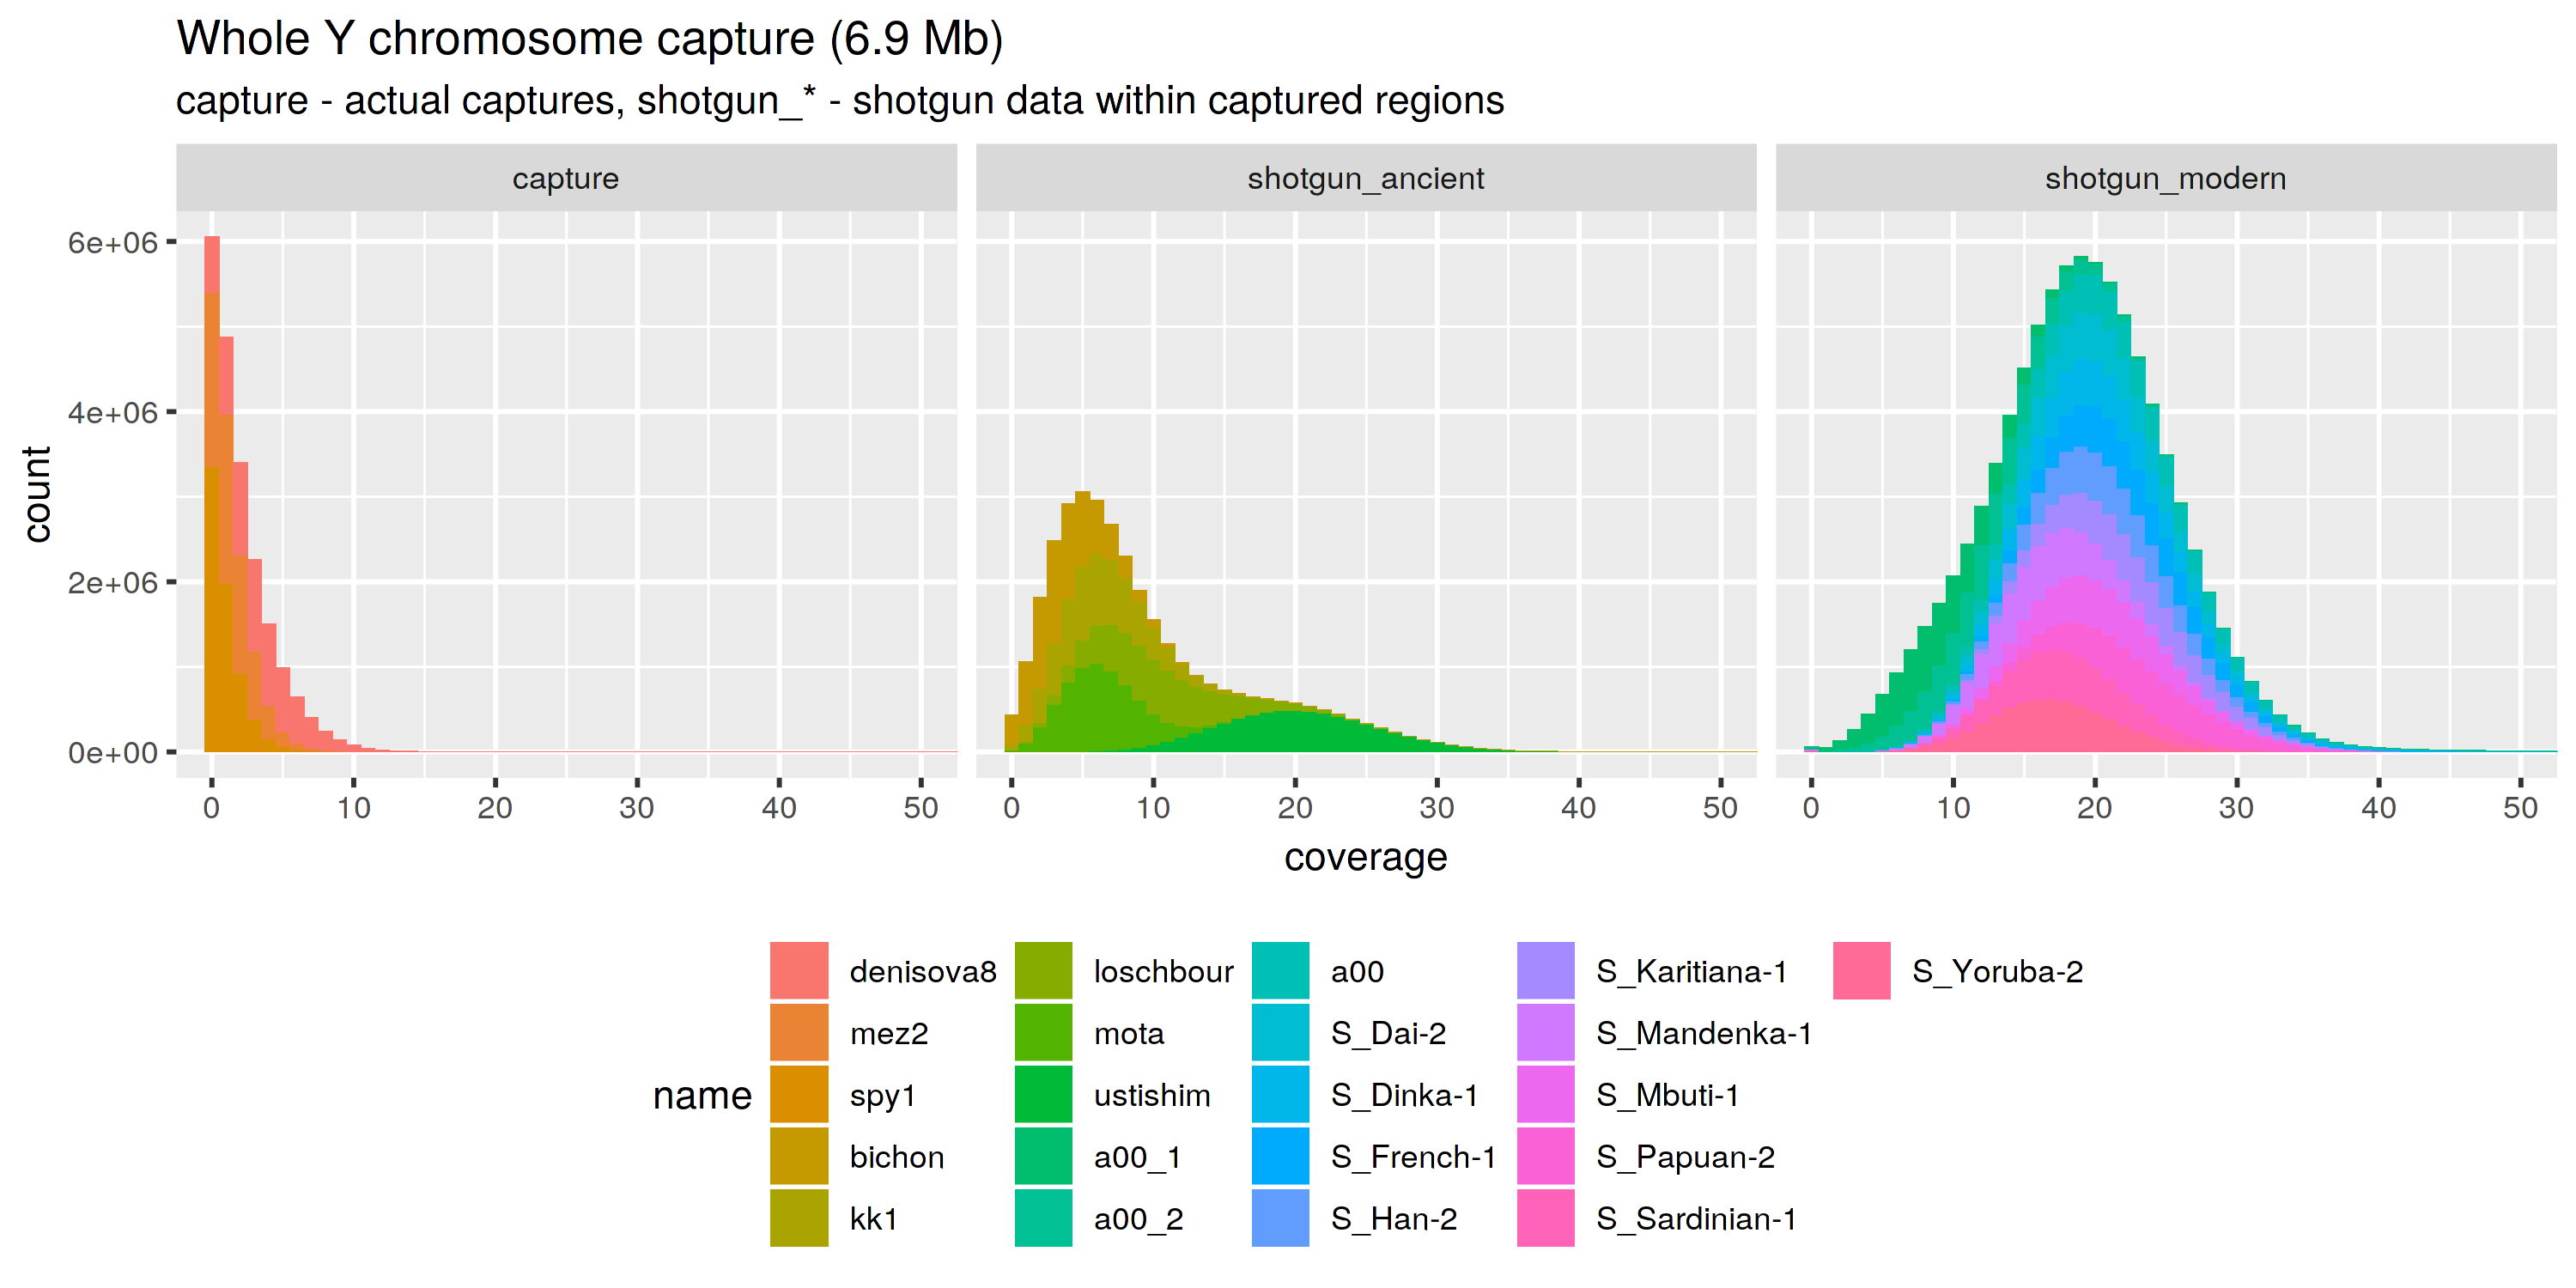

In [40]:
set_dim(10, 5, 300)

cov_df %>%
filter(regions == "full") %>%
mutate(name = factor(name, levels = factors)) %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ set) +
    theme(legend.position = "bottom") +
    ggtitle("Whole Y chromosome capture (6.9 Mb)",
            "capture - actual captures, shotgun_* - shotgun data within captured regions")